In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc
from scipy.fftpack import fftn, fftshift
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# 1) Input Data 

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")

In [3]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [7]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))

eta = np.transpose(wamos, (1, 2, 0))

Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

Norm = dKx * dKy * dW 

In [8]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# 2) Get Triplets

## 2.1) HP Filter

In [11]:
I_0 = power_Spectrum

w_cut = 0.03 * 2*np.pi
w_cut

0.18849555921538758

In [12]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [14]:
I_1 = np.where(mask[ None, None,:], I_0, 0) 

## 2.2) Energy Threshold

In [15]:
P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [16]:
I_2 = np.where(condition[:, :, None], I_1, 0)

## 2.3) Identify Peaks

In [20]:
def identification(kx, ky, ratio, prominence, distance):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)

        if len(peaks) == 1:
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            try_sort = list(set(y[peaks]))
            try_sort.sort()
            ind = np.where(y[peaks]==np.max(y[peaks]))
            thing = []

            for k in range(len(peaks)):
                if np.max(y[peaks]) >= ratio*try_sort[-2]:
                    wj[kx,ky] = w[peaks[ind]]
                    
    return wj 

In [21]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=3, prominence=0.1*np.max(y), distance=10))

In [22]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

w0 = w0_2D[w0_2D != 0]

nonzero_indices = np.nonzero(w0_2D)
nonzero_indices

(array([51, 51, 53, 54, 54, 54, 54, 55, 55, 56, 56, 56, 57, 58, 58, 59, 59,
        59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63,
        64, 64, 64, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 67, 68, 68, 68,
        68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70,
        70, 70, 70, 71, 71, 71, 72, 72, 72, 72, 73, 74, 75, 75, 76, 77, 78],
       dtype=int64),
 array([56, 57, 57, 54, 55, 57, 58, 54, 56, 53, 54, 55, 51, 50, 53, 53, 54,
        78, 49, 51, 53, 50, 52, 53, 46, 73, 80, 47, 49, 53, 69, 73, 74, 76,
        70, 72, 73, 72, 73, 54, 67, 72, 74, 67, 68, 69, 73, 74, 49, 53, 54,
        68, 69, 70, 72, 73, 80, 48, 54, 67, 68, 69, 74, 45, 47, 54, 67, 68,
        73, 75, 76, 49, 67, 74, 50, 65, 67, 73, 49, 48, 50, 80, 76, 75, 52],
       dtype=int64))

In [23]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [24]:
%matplotlib widget

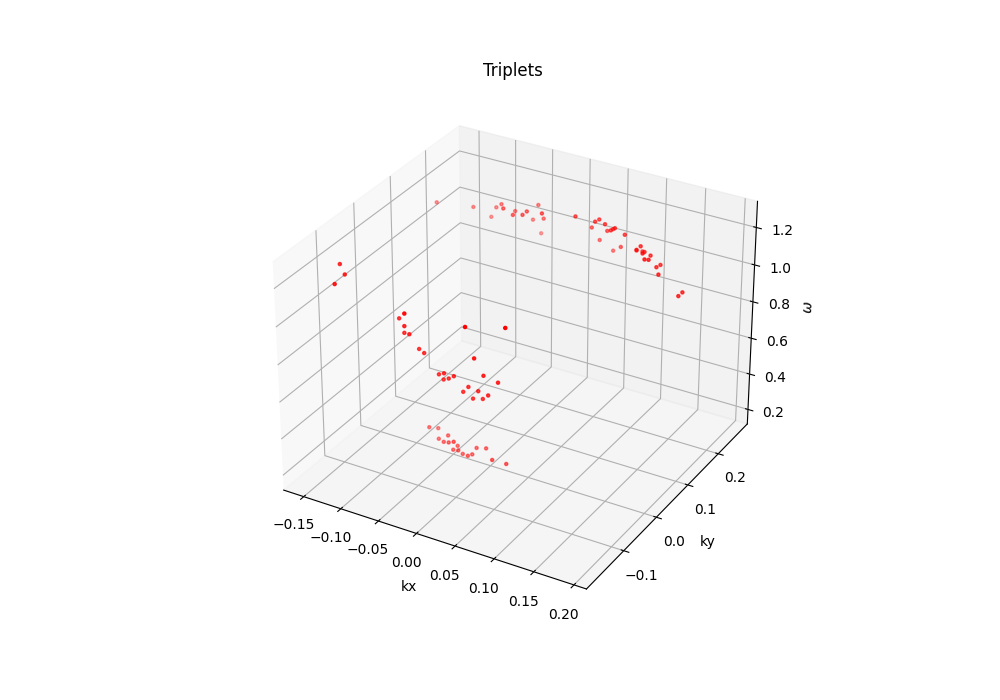

In [31]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0, color = "red", s = 5)
plt.title("Triplets")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

# show plot
plt.show()

In [32]:
cond = (-ky_trip < -0.065)

# Filtering out aliased and low wavenumbers

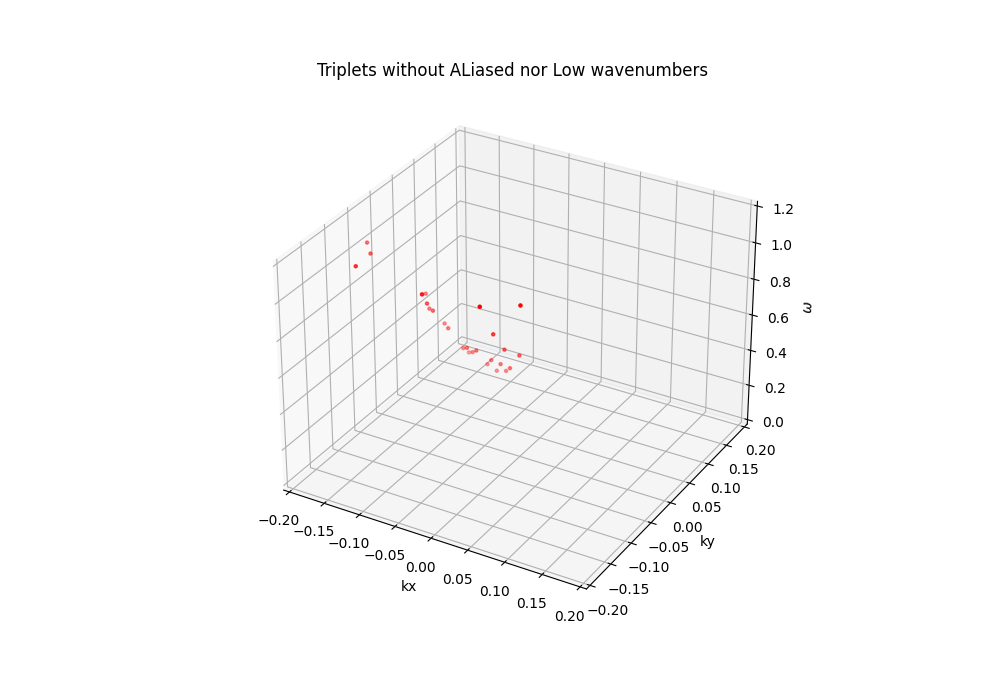

In [33]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip[cond], -ky_trip[cond], w0[cond], color = "red", s = 5)
plt.title("Triplets without ALiased nor Low wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

# 3) Surface Interpolation 

In [78]:
%matplotlib widget

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from numpy import ones, vstack
from numpy.linalg import lstsq

In [80]:
x = np.insert(-kx_trip[cond], 0, 0)
y = np.insert(-ky_trip[cond], 0, 0)
z = np.insert(w0[cond], 0, 0)

# Add point at (0,0,0) to improve interpolation

[ 6.40778815e-03 -2.86552542e+00 -9.93726249e+00  1.44606551e+01
 -1.92487751e+01 -2.08073533e+01]


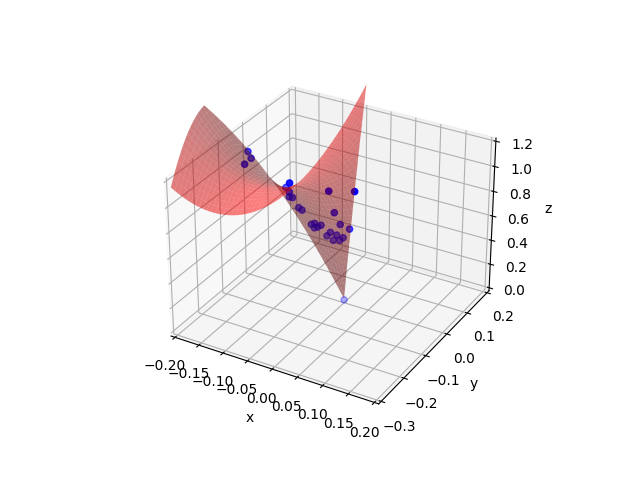

In [81]:
# Find the maximum and minimum x values
i_max, = np.where(np.isclose(x, np.max(x)))
i_min, = np.where(np.isclose(x, np.min(x)))
x_max = x[i_max][0]
x_min = x[i_min][0]

# Find the corresponding y values (i.e. y values of those points where x is maximum)
y_max = y[i_max][0]
y_min = y[i_min][0]

# Function finding 2D-line coefficients, based on this answer https://stackoverflow.com/a/21566184/3715182
def line_coeffs(points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords, ones(len(x_coords))]).T
    # y = a*x + b
    a, b = lstsq(A, y_coords, rcond=None)[0]
    return (a, b)

# Find coefficients of the two lines "limiting" all points left and right across the x-axis in the XY-plane
k1_max, k2_max = line_coeffs([(x_max, y_max), (0, 0)])
k1_min, k2_min = line_coeffs([(x_min, y_min), (0, 0)])
  
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y
  
# Perform curve fitting 
popt, pcov = curve_fit(func, (x, y), z)
  
# Print optimized parameters 
print(popt)
  
# Create 3D plot of the data points and the fitted curve 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue')
x_range = np.linspace(-0.2, 0.2, 1000)
y_range = np.linspace(-0.3, 0.2, 1000)
X, Y = np.meshgrid(x_range, y_range)
Z = func((X, Y), *popt)
# Limit the surface with a condition, forcing its XY-projections to be within the area limited by two lines
ax.plot_surface(np.where(X >= (Y - k2_min)/k1_min, np.where(X <= (Y - k2_max)/k1_max, X, np.nan), np.nan), Y, Z, color='red', alpha=0.5)

ax.set_xlim([-0.2, 0.2])
ax.set_ylim([-0.3, 0.2])
ax.set_zlim([0,1.2])

ax.set_xlabel('x')  
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

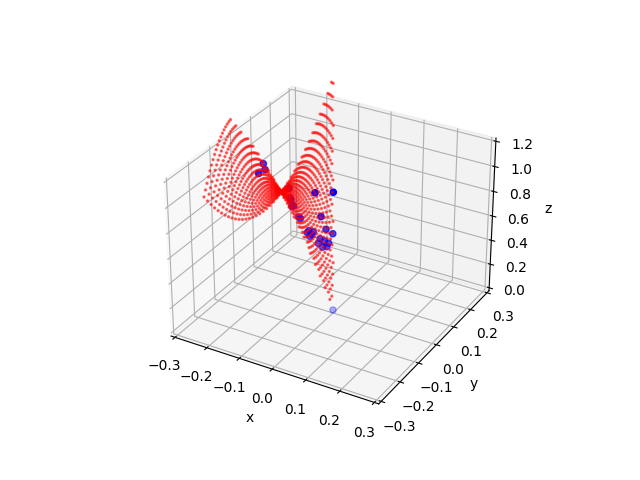

In [82]:
# Find the maximum and minimum x values
i_max, = np.where(np.isclose(x, np.max(x)))
i_min, = np.where(np.isclose(x, np.min(x)))
x_max = x[i_max][0]
x_min = x[i_min][0]

# Find the corresponding y values (i.e. y values of those points where x is maximum)
y_max = y[i_max][0]
y_min = y[i_min][0]

# Function finding 2D-line coefficients, based on this answer https://stackoverflow.com/a/21566184/3715182
def line_coeffs(points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords, ones(len(x_coords))]).T
    # y = a*x + b
    a, b = lstsq(A, y_coords, rcond=None)[0]
    return (a, b)

# Find coefficients of the two lines "limiting" all points left and right across the x-axis in the XY-plane
k1_max, k2_max = line_coeffs([(x_max, y_max), (0, 0)])
k1_min, k2_min = line_coeffs([(x_min, y_min), (0, 0)])

# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

# Create a grid of points over the surface
x_fill = np.linspace(-0.2, 0.2, 40)
y_fill = np.linspace(-0.3, 0, 40)
X_fill, Y_fill = np.meshgrid(x_fill, y_fill)

# Evaluate the function at each point on the surface
Z_fill = func((X_fill, Y_fill), *popt)

# Plot the data points and the filled surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue', label='Data Points')

ax.scatter(np.where(X_fill >= (Y_fill - k2_min)/k1_min, np.where(X_fill <= (Y_fill - k2_max)/k1_max, X_fill, np.nan), np.nan), Y_fill, Z_fill, color='red', alpha=0.5, s= 2)

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
ax.set_zlim([0, 1.2])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

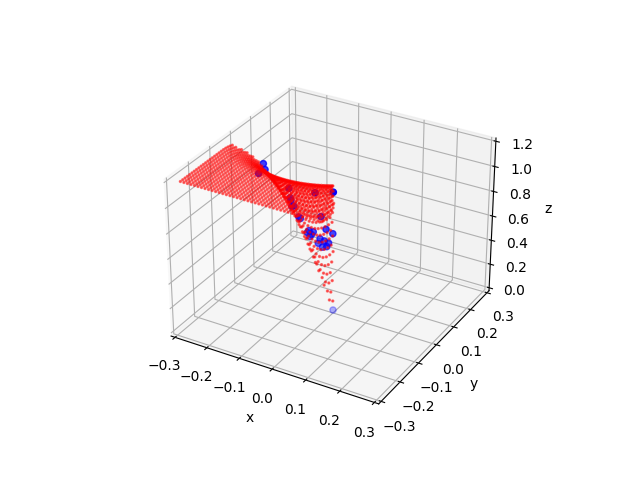

In [83]:
# Find the maximum and minimum x values
i_max, = np.where(np.isclose(x, np.max(x)))
i_min, = np.where(np.isclose(x, np.min(x)))
x_max = x[i_max][0]
x_min = x[i_min][0]

# Find the corresponding y values (i.e. y values of those points where x is maximum)
y_max = y[i_max][0]
y_min = y[i_min][0]

# Function finding 2D-line coefficients, based on this answer https://stackoverflow.com/a/21566184/3715182
def line_coeffs(points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords, ones(len(x_coords))]).T
    # y = a*x + b
    a, b = lstsq(A, y_coords, rcond=None)[0]
    return (a, b)

# Find coefficients of the two lines "limiting" all points left and right across the x-axis in the XY-plane
k1_max, k2_max = line_coeffs([(x_max, y_max), (0, 0)])
k1_min, k2_min = line_coeffs([(x_min, y_min), (0, 0)])

def func(xy, a, b, c):
    x, y = xy
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(x, y)
    parabola = a*(r - b)**2 + c
    return np.where(r <= b, parabola, c)

# Create a grid of points over the surface
x_fill = np.linspace(-0.2, 0.2, 40)
y_fill = np.linspace(-0.4, 0, 40)
X_fill, Y_fill = np.meshgrid(x_fill, y_fill)

# Perform curve fitting 
popt, pcov = curve_fit(func, (x, y), z)

# Evaluate the function at each point on the surface
Z_fill = func((X_fill, Y_fill), *popt)

# Plot the data points and the filled surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue', label='Data Points')

ax.scatter(np.where(X_fill >= (Y_fill - k2_min)/k1_min, np.where(X_fill <= (Y_fill - k2_max)/k1_max, X_fill, np.nan), np.nan), Y_fill, Z_fill, color='red', alpha=0.5, s= 2)

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
ax.set_zlim([0, 1.2])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [55]:
# Find the interpolated points
interpolated_points_x = np.where(X_fill >= (Y_fill - k2_min) / k1_min,
                                  np.where(X_fill <= (Y_fill - k2_max) / k1_max, X_fill, np.nan), np.nan).flatten()
interpolated_points_y = Y_fill.flatten()
interpolated_points_z = Z_fill.flatten()

In [56]:
not_nan_indices = np.where(~np.isnan(interpolated_points_x))

In [57]:
kx_triplets = interpolated_points_x[not_nan_indices]
ky_triplets = interpolated_points_y[not_nan_indices]
w_triplets = interpolated_points_z[not_nan_indices]

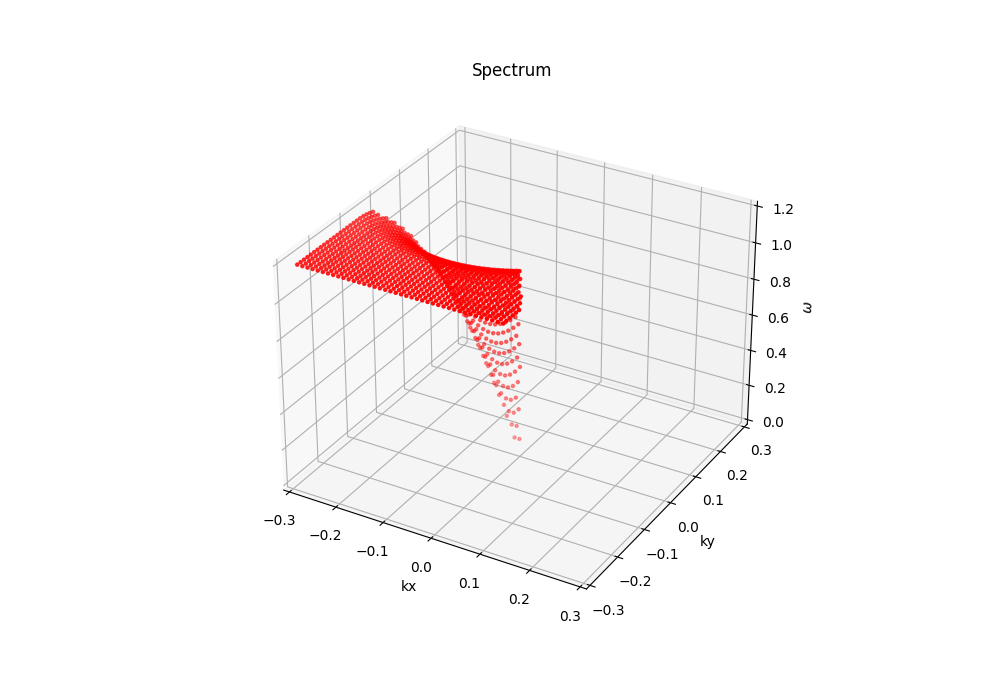

In [58]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(kx_triplets, ky_triplets, w_triplets, color = "red", s = 5)
plt.title("Spectrum")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
ax.set_zlim([0, 1.2])
 
# show plot
plt.show()

# 4) Perform PCS Method

In [70]:
%matplotlib inline

In [71]:
from scipy.stats import t

In [72]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b) 

In [73]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [74]:
#cut_k_array = np.arange(0.001, 0.35, 0.01)
cut_k_array = np.arange(0.05, 0.3, 0.01)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]
    
    k_abs = np.sqrt(kx_triplets**2 + ky_triplets**2)
    theta = np.arctan2(ky_triplets, kx_triplets)
    
    reso = 0.005
    ind = np.where(((k_slice - reso) < k_abs ) & ( k_abs < (k_slice + reso)))
    
    if len(w_triplets[ind]) > 10:
    
        x1 = theta[ind]
        y = ( w_triplets[ind] - np.sqrt(9.81*k_slice) )  / k_slice
    
        # Perform Grubbs test
        x1, y = grubbs_test(x1, y)
    
    
        # initial guess
        pars0 = ( max(y), 1)
        popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
            # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    
    else:
        U_array.append(None)
        Φ_array.append(None)

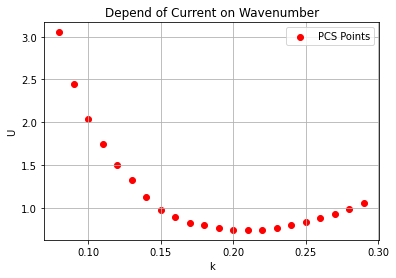

In [75]:
plt.scatter(cut_k_array, U_array, color = 'red', label = 'PCS Points')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
#plt.xlim(0.15, 0.2)
#plt.ylim(0,2)

(-3.141592653589793, 3.141592653589793)

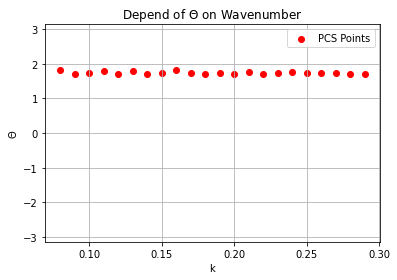

In [77]:
plt.scatter(cut_k_array,Φ_array, color = 'red', label = 'PCS Points')

plt.xlabel("k")
plt.ylabel("$\Theta$")
plt.title("Depend of $\Theta$ on Wavenumber")
plt.grid(True)
plt.legend()
plt.ylim(-np.pi,np.pi)